<a href="https://colab.research.google.com/github/kuralez/honeypot/blob/main/MLENDSEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random

import folium
from folium.plugins import HeatMap

import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.ticker as ticker
import plotly.figure_factory as ff

from pandas_datareader import data
from scipy import stats
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler

from matplotlib.ticker import FixedFormatter, FixedLocator

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AWS_Honeypot_marx-geo.csv")

In [ ]:
month_list = ['Jan.', 'Feb.', 'Mar.', 'Apr.', 'May', 'June', 'July', 'Aug.', 'Sept.', 'Oct.', 'Nov.', 'Dec.']
attack_date = {"year": [], "month": [], "day": [], "time": [], "hour": []}

for d_date in df['datetime']:
    d_date = d_date.split('/')
    mon = d_date[0]
    day = d_date[1]

    year_time = d_date[2].split(' ')
    year = year_time[0]
    time = year_time[1]

    attack_date["year"].append(year)
    attack_date["month"].append(month_list[int(mon) + 1])
    attack_date["day"].append(day)
    attack_date["time"].append(time)
    attack_date["hour"].append(f"{time.split(':')[0]}h")

df["year"] = attack_date["year"]
df["month"] = attack_date["month"]
df["day"] = attack_date["day"]
df["time"] = attack_date["time"]
df["hour"] = attack_date["hour"]

In [ ]:
dt = df
df.head(20)

datetime               host         src proto  type      spt     dpt  \
0   3/3/13 21:53     groucho-oregon  1032051418   TCP   NaN   6000.0  1433.0   
1   3/3/13 21:57     groucho-oregon  1347834426   UDP   NaN   5270.0  5060.0   
2   3/3/13 21:58     groucho-oregon  2947856490   TCP   NaN   2489.0  1080.0   
3   3/3/13 21:58    groucho-us-east   841842716   UDP   NaN  43235.0  1900.0   
4   3/3/13 21:58  groucho-singapore  3587648279   TCP   NaN  56577.0    80.0   
5   3/3/13 21:58      groucho-tokyo  3323217250   TCP   NaN  32628.0  2323.0   
6   3/3/13 21:59     groucho-oregon  3730416887   TCP   NaN   6000.0  1433.0   
7   3/3/13 22:07  groucho-singapore  3738622573   TCP   NaN   6000.0  3306.0   
8   3/3/13 22:12     groucho-oregon  3683919430   TCP   NaN   6000.0  1433.0   
9   3/3/13 22:14  groucho-singapore  1007884304   TCP   NaN   6000.0  1433.0   
10  3/3/13 22:14      groucho-tokyo  3639889826   TCP   NaN   6000.0  1433.0   
11  3/3/13 22:20     groucho-oregon  1965603898   TCP   NaN   9907.0  1433.0   
12  3/3/13 22:20         groucho-sa  3672981807   TCP   NaN  33367.0    22.0   
13  3/3/13 22:20       zeppo-norcal  3672981807   TCP   NaN  33367.0    22.0   
14  3/3/13 22:19     groucho-norcal  3672981807   TCP   NaN  33367.0    22.0   
15  3/3/13 22:20    groucho-us-east  3672981807   TCP   NaN  33367.0    22.0   
16  3/3/13 22:21         groucho-eu  3672981807   TCP   NaN  33367.0    22.0   
17  3/3/13 22:21     groucho-sydney  3672981807   TCP   NaN  33367.0    22.0   
18  3/3/13 22:23     groucho-oregon  2382398543   TCP   NaN   6000.0  1433.0   
19  3/3/13 22:26      groucho-tokyo  1965603898   TCP   NaN  26180.0  1433.0   

             srcstr  cc        country  ... localeabbr postalcode latitude  \
0    61.131.218.218  CN          China  ...         36        NaN  28.5500   
1       80.86.82.58  DE        Germany  ...        NaN        NaN  51.0000   
2   175.180.184.106  TW         Taiwan  ...        NaN        NaN  25.0392   
3      50.45.128.28  US  United States  ...         OR      97124  45.5848   
4     213.215.43.23  FR         France  ...        NaN        NaN  48.8600   
5      198.20.69.98  US  United States  ...         IL      60661  41.8825   
6    222.89.164.247  CN          China  ...         41        NaN  34.6836   
7   222.214.218.109  CN          China  ...         51        NaN  30.6667   
8     219.148.38.70  CN          China  ...         13        NaN  39.8897   
9       60.19.24.16  CN          China  ...         21        NaN  41.7922   
10   216.244.79.162  US  United States  ...         WA      98168  47.4891   
11    117.40.188.58  CN          China  ...         36        NaN  28.5500   
12    218.237.65.47  KR    South Korea  ...         11        NaN  37.4906   
13    218.237.65.47  KR    South Korea  ...         11        NaN  37.4906   
14    218.237.65.47  KR    South Korea  ...         11        NaN  37.4906   
15    218.237.65.47  KR    South Korea  ...         11        NaN  37.4906   
16    218.237.65.47  KR    South Korea  ...         11        NaN  37.4906   
17    218.237.65.47  KR    South Korea  ...         11        NaN  37.4906   
18     142.0.132.79  US  United States  ...         CA      94024  37.3495   
19    117.40.188.58  CN          China  ...         36        NaN  28.5500   

    longitude  Unnamed: 15  year month day   time hour  
0    115.9333          NaN    13   May   3  21:53  21h  
1      9.0000          NaN    13   May   3  21:57  21h  
2    121.5250          NaN    13   May   3  21:58  21h  
3   -122.9117          NaN    13   May   3  21:58  21h  
4      2.3500          NaN    13   May   3  21:58  21h  
5    -87.6441          NaN    13   May   3  21:58  21h  
6    113.5325          NaN    13   May   3  21:59  21h  
7    104.0667          NaN    13   May   3  22:07  22h  
8    115.2750          NaN    13   May   3  22:12  22h  
9    123.4328          NaN    13   May   3  22:14  22h  
10  -122.2908          NaN    13   May   3  22:14  22h  
11  

In [ ]:
def bar_plot_data(df: dict, field: str, subtitle: str, figsize=(5, 4), top_filter=15):
    fig, ax1 = plt.subplots(figsize=figsize, dpi=100)

    for spline in ['top', 'right', 'left']:
        ax1.spines[spline].set_visible(False)

    df_filter = df[field].value_counts().rename_axis(field).reset_index(name='counts')
    if top_filter:
        df_filter = df_filter.head(top_filter)
    sns.barplot(data=df_filter, palette='cool', x='counts', y=field)
    ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
    ax1.set_xlabel(f'count', fontsize=13, color = '#333F4B')
    ax1.set_ylabel(f'{field}', fontsize=13, color = '#333F4B')

    plt.plot(color="white", lw=3)
    fig.suptitle(subtitle, fontsize=18)
    plt.show()

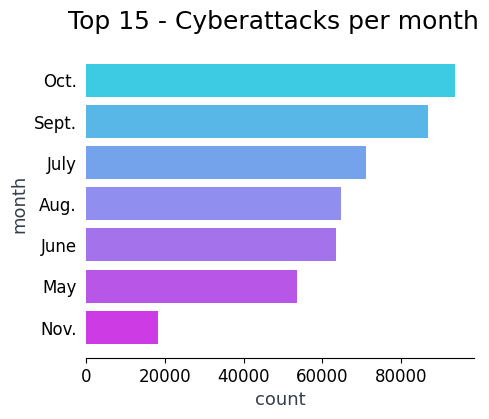

In [ ]:
bar_plot_data(df, 'month', 'Top 15 - Cyberattacks per month')

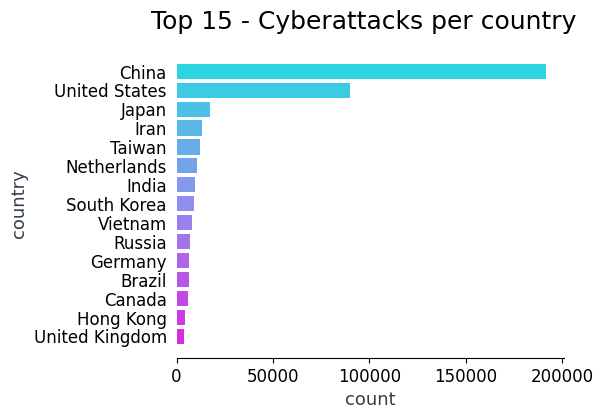

In [ ]:
bar_plot_data(df, 'country', 'Top 15 - Cyberattacks per country')

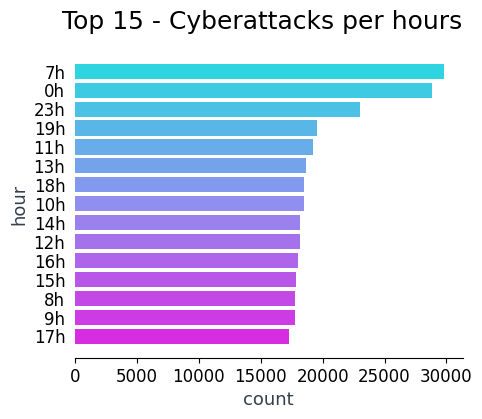

In [ ]:
bar_plot_data(df, 'hour', 'Top 15 - Cyberattacks per hours')

In [ ]:
df['srcstr'].value_counts().rename_axis('ipaddress').reset_index(name='counts')

ipaddress  counts
0      175.146.199.252   18472
1        2.186.189.218   11116
2       203.178.148.19    7086
3         128.9.168.98    7046
4        129.82.138.44    6772
...                ...     ...
69597   113.161.81.118       1
69598  116.252.182.193       1
69599     113.81.65.41       1
69600   122.144.11.167       1
69601  175.201.224.104       1

[69602 rows x 2 columns]

In [ ]:
def get_pie_plot_count(df: dict, field: str, subtitle: str):
    fig, ax1 = plt.subplots(figsize=(10, 6), dpi=100)
    colors = sns.color_palette('cool')
    df_filter = df[field].value_counts().rename_axis(field).reset_index(name='counts')
    ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
    plt.pie(df_filter['counts'], colors=colors, labels=df_filter[field], autopct = '%0.0f%%',
            startangle=90,  textprops={'fontsize': 14})

    plt.plot(color="white", lw=3)
    fig.suptitle(subtitle, fontsize=18)
    plt.show()

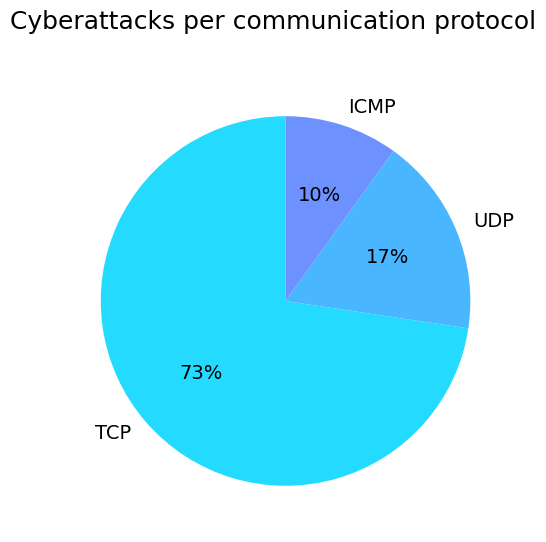

In [ ]:
get_pie_plot_count(df, 'proto', 'Cyberattacks per communication protocol')

In [ ]:
attack= df[['latitude','longitude']]
attack.latitude.fillna(0, inplace = True)
attack.longitude.fillna(0, inplace = True)

World =folium.Map(location=[0,0],zoom_start=2)
HeatMap(data=attack, radius=16).add_to(World)

print('Top cyberattacks by country')
World

In [ ]:
def get_histplot_central_tendency(df: dict, fields: list):
    colors = sns.color_palette('cool')
    for field in fields:
        f, (ax1) = plt.subplots(figsize=(10, 5), dpi=100)
        v_dist_1 = df[field].values

        for spline in ['top', 'right', 'left']:
            ax1.spines[spline].set_visible(False)

        sns.histplot(v_dist_1, ax=ax1, palette=colors, kde=True)

        mean=df[field].mean()
        median=df[field].median()
        mode=df[field].mode().values[0]

        ax1.axvline(mean, color='r', linestyle='--', label="Mean")
        ax1.axvline(median, color='g', linestyle='-', label="Mean")
        ax1.axvline(mode, color='b', linestyle='-', label="Mode")
        ax1.tick_params(axis='both', which='both', labelsize=12, bottom=True, left=False)
        ax1.set_xlabel(f'count', fontsize=13, color = '#333F4B')
        ax1.set_ylabel(f'{field}', fontsize=13, color = '#333F4B')
        ax1.legend()
        plt.grid(False)
        plt.plot(color="white", lw=3)
        f.suptitle(f"Representation Histogram for {field}", fontsize=18)

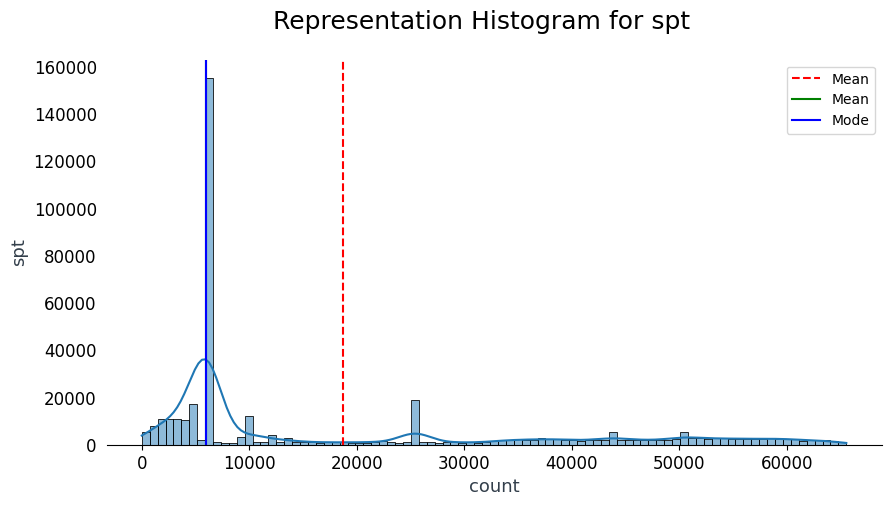

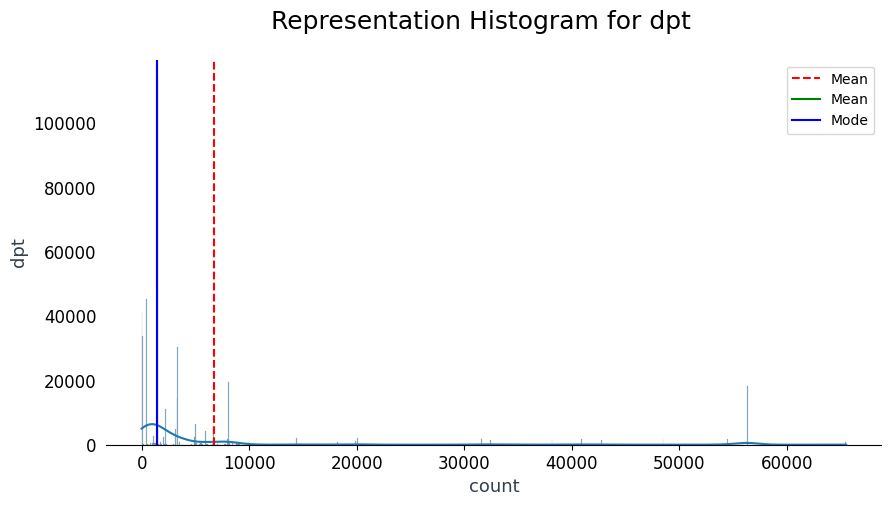

In [ ]:
get_histplot_central_tendency(df, ['spt', 'dpt'])

In [ ]:
df['type'].value_counts().rename_axis('id_type_attack').reset_index(name='counts')

id_type_attack  counts
0             8.0   38597
1             3.0    4251
2            11.0    1156
3             0.0     536
4            13.0     142
5             5.0     127
6            12.0       2

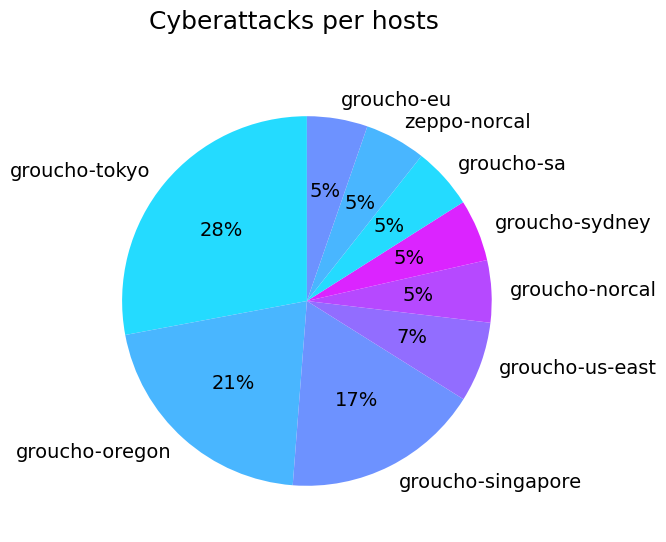

In [ ]:
get_pie_plot_count(df, 'host', 'Cyberattacks per hosts')

In [ ]:
df_filter = df[(df.host == "groucho-oregon") & (df.month == "May") & (df.hour == "20h")]
df_filter

datetime            host         src proto  type      spt     dpt  \
1437    3/4/13 20:00  groucho-oregon  2036715561   TCP   NaN  27984.0    22.0   
1441    3/4/13 20:05  groucho-oregon  3736745024   TCP   NaN   6000.0  1433.0   
1442    3/4/13 20:06  groucho-oregon  3658020275   TCP   NaN   6000.0  1433.0   
1444    3/4/13 20:08  groucho-oregon  3630406730   TCP   NaN   6000.0  1433.0   
1445    3/4/13 20:09  groucho-oregon  1019141837   TCP   NaN   6000.0  1433.0   
...              ...             ...         ...   ...   ...      ...     ...   
53246  3/31/13 20:46  groucho-oregon  1995742862   TCP   NaN   6000.0  1433.0   
53248  3/31/13 20:49  groucho-oregon  3736734735   TCP   NaN   6000.0  1433.0   
53249  3/31/13 20:49  groucho-oregon  3689613428   TCP   NaN   6000.0  1433.0   
53258  3/31/13 20:52  groucho-oregon  3683824005   TCP   NaN   6000.0  1433.0   
53265  3/31/13 20:57  groucho-oregon  1995742035   TCP   NaN   6000.0  3306.0   

                srcstr  cc        country  ... localeabbr postalcode latitude  \
1437    121.101.208.41  CN          China  ...         11        NaN  39.9289   
1441     222.186.52.64  CN          China  ...         32        NaN  32.0617   
1442     218.8.245.179  CN          China  ...         23        NaN  45.7500   
1444     216.99.156.74  US  United States  ...         CA      91789  34.0115   
1445    60.190.222.205  CN          China  ...        NaN        NaN  35.0000   
...                ...  ..            ...  ...        ...        ...      ...   
53246  118.244.158.142  CN          China  ...         11        NaN  39.9289   
53248    222.186.12.15  CN          China  ...         32        NaN  32.0617   
53249    219.235.8.116  CN          China  ...         11        NaN  39.9289   
53258  219.146.177.133  CN          China  ...         37        NaN  36.6683   
53265   118.244.155.83  CN          China  ...         11        NaN  39.9289   

       longitude  Unnamed: 15  year month day   time hour  
1437    116.3883          NaN    13   May   4  20:00  20h  
1441    118.7778          NaN    13   May   4  20:05  20h  
1442    126.6500          NaN    13   May   4  20:06  20h  
1444   -117.8535          NaN    13   May   4  20:08  20h  
1445    105.0000          NaN    13   May   4  20:09  20h  
...          ...          ...   ...   ...  ..    ...  ...  
53246   116.3883          NaN    13   May  31  20:46  20h  
53248   118.7778          NaN    13   May  31  20:49  20h  
53249   116.3883          NaN    13   May  31  20:49  20h  
53258   116.9972          NaN    13   May  31  20:52  20h  
53265   116.3883          NaN    13   May  31  20:57  20h  

[442 rows x 21 columns]

In [ ]:
df_filter['proto'].value_counts()

TCP     392
UDP      35
ICMP     15
Name: proto, dtype: int64

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_node('groucho-oregon', color='red')

ip_listx = []
edge_color = []
for ip, proto in zip(df_filter['srcstr'], df_filter['proto']):
    if ip not in ip_listx:
        if 'TCP' == proto:
            edge_color.append('green')
        if 'UDP' == proto:
            edge_color.append('red')
        if 'ICMP' == proto:
            edge_color.append('orange')
        G.add_node(ip)
        ip_listx.append(ip)

for ip in ip_listx:
    G.add_edge('groucho-oregon', ip)
fig = plt.figure(1, figsize=(25, 25), dpi=100)
print('TPC == green\nUDP == red\nICMP == orange')
nx.draw(G, with_labels=True, font_weight='normal', edge_color=edge_color, arrowsize=30, arrowstyle='fancy')

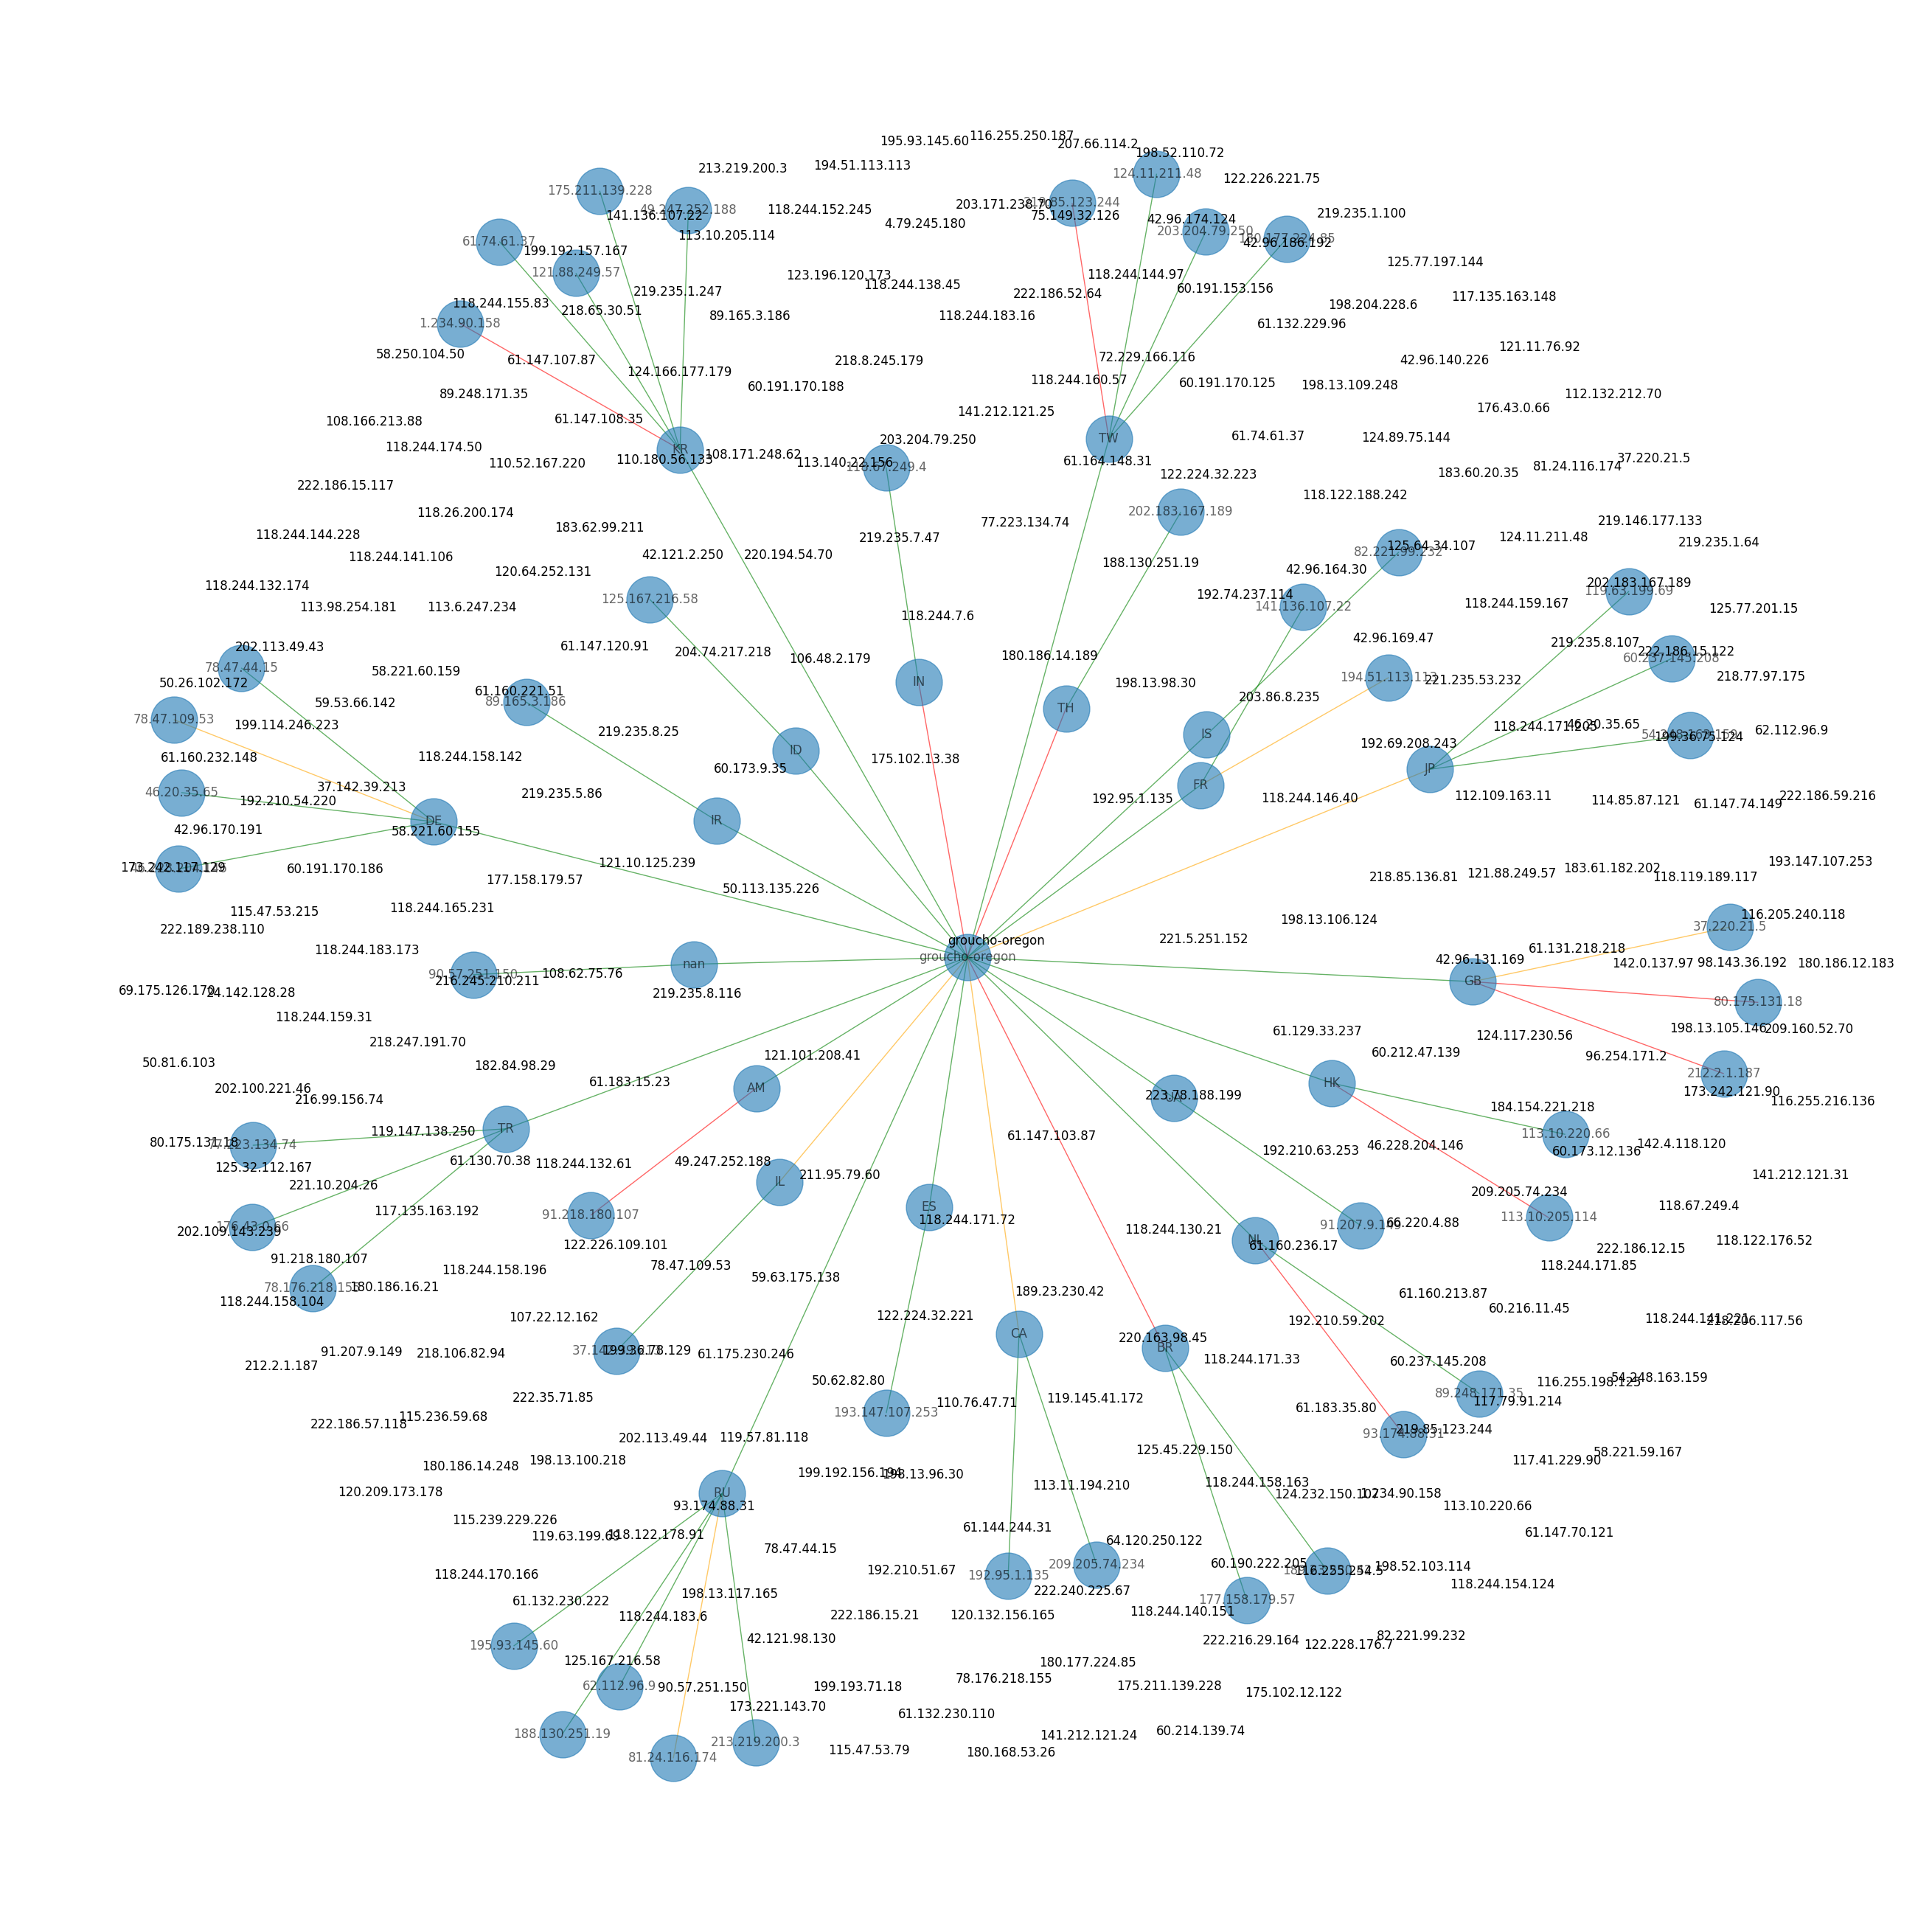

In [ ]:
from matplotlib.pyplot import figure, text

Gx = nx.Graph()
Gx.add_node('groucho-oregon')

country_list = []
ip_list = []
edge_color = []
for country, ip, proto in zip(df_filter['cc'], df_filter['srcstr'], df_filter['proto']):
    if country != 'CN' and country != 'US':
        if country not in country_list:
            Gx.add_node(country)
            country_list.append(country)

        if ip not in ip_list:
            if 'TCP' == proto:
                edge_color.append('green')
            if 'UDP' == proto:
                edge_color.append('red')
            if 'ICMP' == proto:
                edge_color.append('orange')

            Gx.add_node(ip)
            Gx.add_edge(country, ip)
            ip_list.append(ip)


for country in country_list:
    Gx.add_edge('groucho-oregon', country)

options = {
    "node_color": "black",
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
}


pos = nx.spring_layout(G)
d = dict(G.degree)
fig = plt.figure(figsize=(26, 26), dpi=100)
nx.draw(Gx, alpha=0.6, node_size=2050, with_labels=True, font_weight='normal',
        edge_color=edge_color, arrowsize=30, arrowstyle='fancy')

for node, (x, y) in pos.items():
    text(x, y, node, fontsize=12)

In [ ]:
df_filter = df[(df.host == "groucho-tokyo") & (df.month == "May") & (df.hour == "20h")]
df_filter

datetime           host         src proto  type      spt     dpt  \
1438    3/4/13 20:03  groucho-tokyo  1965603898   TCP   NaN  47445.0  1433.0   
1439    3/4/13 20:04  groucho-tokyo  1416369259   TCP   NaN   3566.0   445.0   
1440    3/4/13 20:04  groucho-tokyo  1416369259   TCP   NaN   3566.0   445.0   
1448    3/4/13 20:14  groucho-tokyo  1033947182   TCP   NaN   6000.0  1433.0   
1454    3/4/13 20:18  groucho-tokyo  2095620464   TCP   NaN   6000.0  3306.0   
...              ...            ...         ...   ...   ...      ...     ...   
53236  3/31/13 20:40  groucho-tokyo  2083147011   TCP   NaN   6000.0  3306.0   
53259  3/31/13 20:53  groucho-tokyo  1995746141   TCP   NaN   6000.0  1433.0   
53262  3/31/13 20:54  groucho-tokyo  2013134868   TCP   NaN   6000.0  1433.0   
53263  3/31/13 20:55  groucho-tokyo    32130586   TCP   NaN   6000.0  1433.0   
53264  3/31/13 20:57  groucho-tokyo  3736747955   TCP   NaN   6000.0  6666.0   

                srcstr  cc      country  ... localeabbr postalcode latitude  \
1438     117.40.188.58  CN        China  ...         36        NaN  28.5500   
1439     84.108.20.107  IL       Israel  ...          M        NaN  32.1508   
1440     84.108.20.107  IL       Israel  ...          M        NaN  32.1508   
1448     61.160.200.46  CN        China  ...         32        NaN  32.0617   
1454   124.232.161.112  CN        China  ...         43        NaN  28.1792   
...                ...  ..          ...  ...        ...        ...      ...   
53236      124.42.77.3  CN        China  ...        NaN        NaN  35.0000   
53259   118.244.171.93  CN        China  ...         11        NaN  39.9289   
53262     119.254.0.20  CN        China  ...         11        NaN  39.9289   
53263      1.234.70.26  KR  South Korea  ...         11        NaN  37.5985   
53264   222.186.63.179  CN        China  ...         32        NaN  32.0617   

       longitude  Unnamed: 15  year month day   time hour  
1438    115.9333          NaN    13   May   4  20:03  20h  
1439     34.8883          NaN    13   May   4  20:04  20h  
1440     34.8883          NaN    13   May   4  20:04  20h  
1448    118.7778          NaN    13   May   4  20:14  20h  
1454    113.1136          NaN    13   May   4  20:18  20h  
...          ...          ...   ...   ...  ..    ...  ...  
53236   105.0000          NaN    13   May  31  20:40  20h  
53259   116.3883          NaN    13   May  31  20:53  20h  
53262   116.3883          NaN    13   May  31  20:54  20h  
53263   126.9783          NaN    13   May  31  20:55  20h  
53264   118.7778          NaN    13   May  31  20:57  20h  

[354 rows x 21 columns]

In [ ]:
df_filter['proto'].value_counts()

TCP     305
UDP      41
ICMP      8
Name: proto, dtype: int64

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_node('groucho-tokyo', color='red')

ip_listx = []
edge_color = []
for ip, proto in zip(df_filter['srcstr'], df_filter['proto']):
    if ip not in ip_listx:
        if 'TCP' == proto:
            edge_color.append('green')
        if 'UDP' == proto:
            edge_color.append('red')
        if 'ICMP' == proto:
            edge_color.append('orange')
        G.add_node(ip)
        ip_listx.append(ip)

for ip in ip_listx:
    G.add_edge('groucho-tokyo', ip)
fig = plt.figure(1, figsize=(25, 25), dpi=100)
print('TPC == green\nUDP == red\nICMP == orange')
nx.draw(G, with_labels=True, font_weight='normal', edge_color=edge_color, arrowsize=30, arrowstyle='fancy')

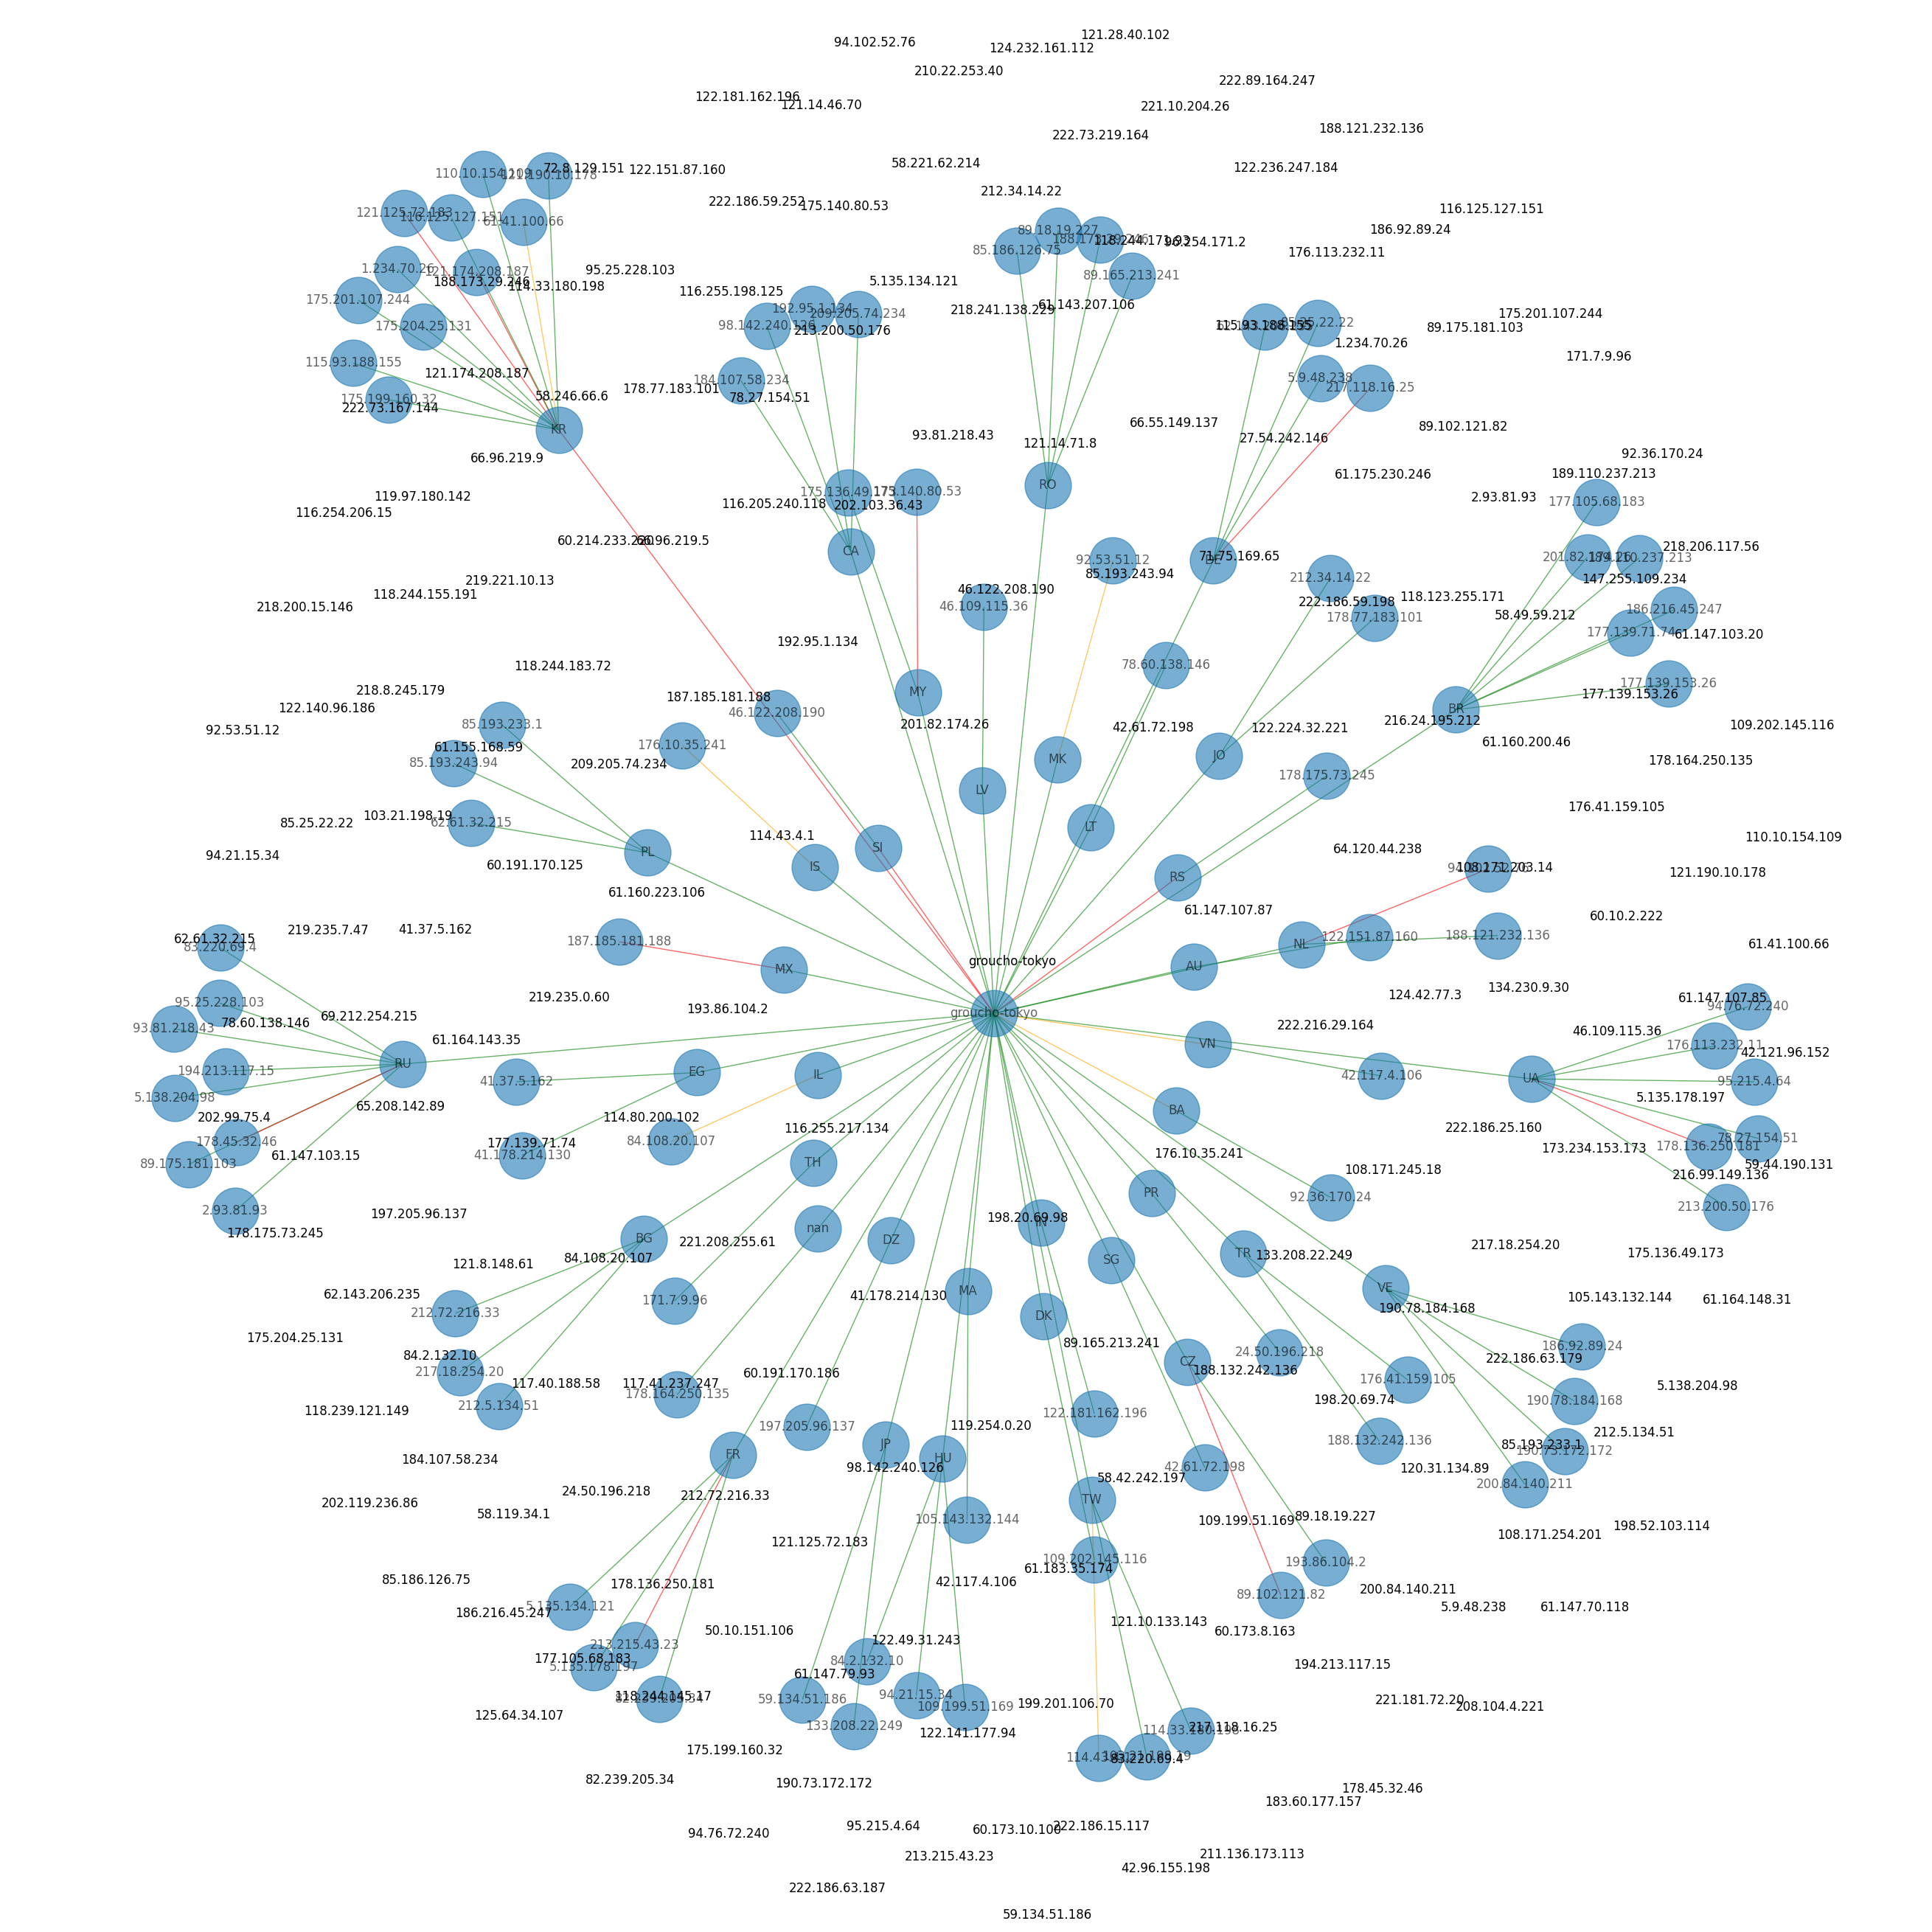

In [ ]:
from matplotlib.pyplot import figure, text

Gx = nx.Graph()
Gx.add_node('groucho-tokyo')

country_list = []
ip_list = []
edge_color = []
for country, ip, proto in zip(df_filter['cc'], df_filter['srcstr'], df_filter['proto']):
    if country != 'CN' and country != 'US':
        if country not in country_list:
            Gx.add_node(country)
            country_list.append(country)

        if ip not in ip_list:
            if 'TCP' == proto:
                edge_color.append('green')
            if 'UDP' == proto:
                edge_color.append('red')
            if 'ICMP' == proto:
                edge_color.append('orange')

            Gx.add_node(ip)
            Gx.add_edge(country, ip)
            ip_list.append(ip)


for country in country_list:
    Gx.add_edge('groucho-tokyo', country)

options = {
    "node_color": "black",
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
}


pos = nx.spring_layout(G)
d = dict(G.degree)
fig = plt.figure(figsize=(26, 26), dpi=100)
nx.draw(Gx, alpha=0.6, node_size=2050, with_labels=True, font_weight='normal',
        edge_color=edge_color, arrowsize=30, arrowstyle='fancy')

for node, (x, y) in pos.items():
    text(x, y, node, fontsize=12)

In [ ]:
df_filter = df[(df.host == "groucho-singapore") & (df.month == "May") & (df.hour == "20h")]
df_filter

datetime               host         src proto  type      spt  \
1443    3/4/13 20:06  groucho-singapore  1365892595   UDP   NaN   5061.0   
1447    3/4/13 20:12  groucho-singapore  3323217250   UDP   NaN  49008.0   
1458    3/4/13 20:19  groucho-singapore  1885002499   TCP   NaN   6000.0   
1460    3/4/13 20:25  groucho-singapore  3344129608   TCP   NaN   6000.0   
1463    3/4/13 20:27  groucho-singapore  1170463282   TCP   NaN  14663.0   
...              ...                ...         ...   ...   ...      ...   
53235  3/31/13 20:38  groucho-singapore  1033070415   TCP   NaN   6000.0   
53243  3/31/13 20:40  groucho-singapore  3736747955   TCP   NaN   6000.0   
53244  3/31/13 20:41  groucho-singapore  1033798899   TCP   NaN   6000.0   
53247  3/31/13 20:44  groucho-singapore  1995739409   TCP   NaN  44877.0   
53266  3/31/13 20:56  groucho-singapore  1018853401   TCP   NaN   1591.0   

          dpt          srcstr  cc         country  ... localeabbr postalcode  \
1443   5060.0  81.105.221.243  GB  United Kingdom  ...        NaN        NaN   
1447   1900.0    198.20.69.98  US   United States  ...         IL      60661   
1458   1433.0    112.90.219.3  CN           China  ...         44        NaN   
1460    135.0    199.83.94.72  US   United States  ...         CA      91789   
1463     22.0   69.195.218.50  US   United States  ...         FL      33181   
...       ...             ...  ..             ...  ...        ...        ...   
53235  1433.0   61.147.103.79  CN           China  ...         32        NaN   
53243  6666.0  222.186.63.179  CN           China  ...         32        NaN   
53244  3306.0  61.158.132.243  CN           China  ...         41     450000   
53247  1433.0  118.244.145.17  CN           China  ...         11        NaN   
53266  6666.0   60.186.120.25  CN           China  ...         33        NaN   

      latitude  longitude  Unnamed: 15  year month day   time hour  
1443   51.5000    -0.1300          NaN    13   May   4  20:06  20h  
1447   41.8825   -87.6441          NaN    13   May   4  20:12  20h  
1458   23.1167   113.2500          NaN    13   May   4  20:19  20h  
1460   34.0115  -117.8535          NaN    13   May   4  20:25  20h  
1463   25.8968   -80.1529          NaN    13   May   4  20:27  20h  
...        ...        ...          ...   ...   ...  ..    ...  ...  
53235  32.0617   118.7778          NaN    13   May  31  20:38  20h  
53243  32.0617   118.7778          NaN    13   May  31  20:40  20h  
53244  34.6836   113.5325          NaN    13   May  31  20:41  20h  
53247  39.9289   116.3883          NaN    13   May  31  20:44  20h  
53266  30.2936   120.1614          NaN    13   May  31  20:56  20h  

[360 rows x 21 columns]

In [ ]:
df_filter['proto'].value_counts()

TCP     295
UDP      43
ICMP     22
Name: proto, dtype: int64

In [ ]:
import networkx as nx

G = nx.Graph()
G.add_node('groucho-singapore', color='red')

ip_listx = []
edge_color = []
for ip, proto in zip(df_filter['srcstr'], df_filter['proto']):
    if ip not in ip_listx:
        if 'TCP' == proto:
            edge_color.append('green')
        if 'UDP' == proto:
            edge_color.append('red')
        if 'ICMP' == proto:
            edge_color.append('orange')
        G.add_node(ip)
        ip_listx.append(ip)

for ip in ip_listx:
    G.add_edge('groucho-singapore', ip)
fig = plt.figure(1, figsize=(25, 25), dpi=100)
print('TPC == green\nUDP == red\nICMP == orange')
nx.draw(G, with_labels=True, font_weight='normal', edge_color=edge_color, arrowsize=30, arrowstyle='fancy')

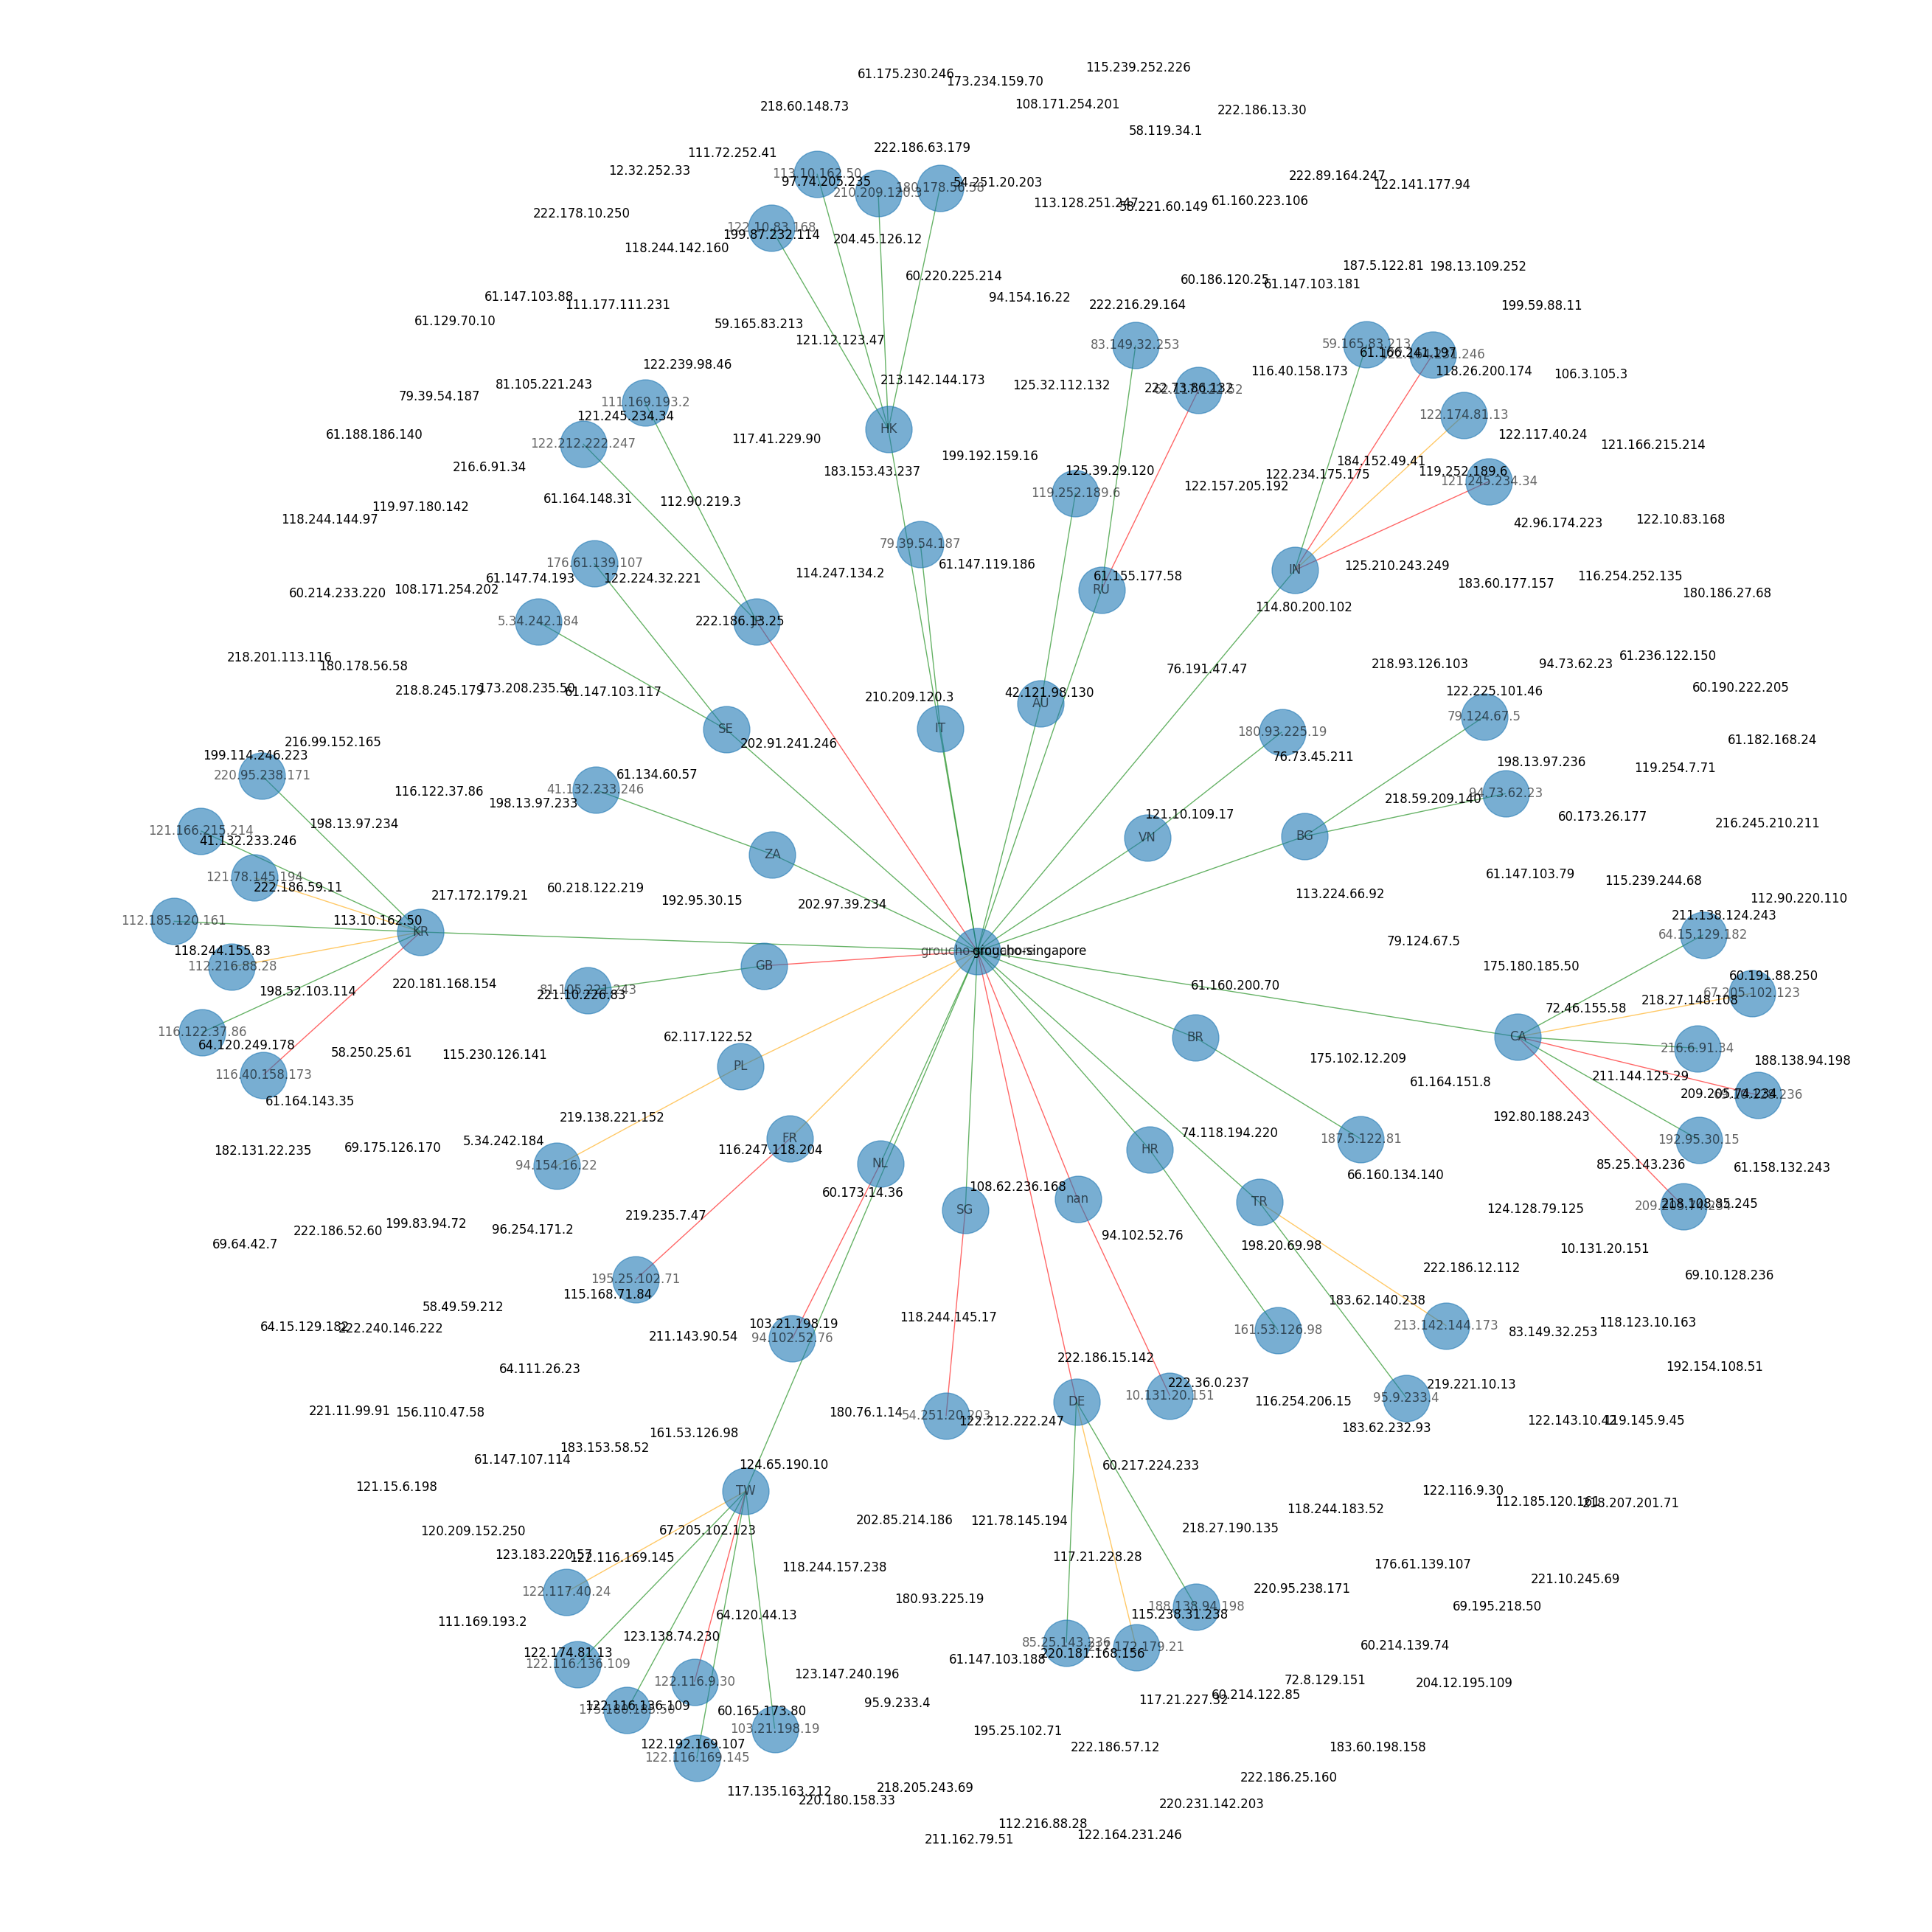

In [ ]:
from matplotlib.pyplot import figure, text

Gx = nx.Graph()
Gx.add_node('groucho-singapore')

country_list = []
ip_list = []
edge_color = []
for country, ip, proto in zip(df_filter['cc'], df_filter['srcstr'], df_filter['proto']):
    if country != 'CN' and country != 'US':
        if country not in country_list:
            Gx.add_node(country)
            country_list.append(country)

        if ip not in ip_list:
            if 'TCP' == proto:
                edge_color.append('green')
            if 'UDP' == proto:
                edge_color.append('red')
            if 'ICMP' == proto:
                edge_color.append('orange')

            Gx.add_node(ip)
            Gx.add_edge(country, ip)
            ip_list.append(ip)


for country in country_list:
    Gx.add_edge('groucho-singapore', country)

options = {
    "node_color": "black",
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
}


pos = nx.spring_layout(G)
d = dict(G.degree)
fig = plt.figure(figsize=(26, 26), dpi=100)
nx.draw(Gx, alpha=0.6, node_size=2050, with_labels=True, font_weight='normal',
        edge_color=edge_color, arrowsize=30, arrowstyle='fancy')

for node, (x, y) in pos.items():
    text(x, y, node, fontsize=12)

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
#df = pd.read_csv("AWS_Honeypot_marx-geo.csv")
df = df.drop('datetime', axis=1)
df.head()

host         src proto  type      spt  \
time                                                                      
2023-04-19 21:53:00     groucho-oregon  1032051418   TCP   NaN   6000.0   
2023-04-19 21:57:00     groucho-oregon  1347834426   UDP   NaN   5270.0   
2023-04-19 21:58:00     groucho-oregon  2947856490   TCP   NaN   2489.0   
2023-04-19 21:58:00    groucho-us-east   841842716   UDP   NaN  43235.0   
2023-04-19 21:58:00  groucho-singapore  3587648279   TCP   NaN  56577.0   

                        dpt           srcstr  cc        country  \
time                                                              
2023-04-19 21:53:00  1433.0   61.131.218.218  CN          China   
2023-04-19 21:57:00  5060.0      80.86.82.58  DE        Germany   
2023-04-19 21:58:00  1080.0  175.180.184.106  TW         Taiwan   
2023-04-19 21:58:00  1900.0     50.45.128.28  US  United States   
2023-04-19 21:58:00    80.0    213.215.43.23  FR         France   

                            locale localeabbr postalcode  latitude  longitude  \
time                                                                            
2023-04-19 21:53:00  Jiangxi Sheng         36        NaN   28.5500   115.9333   
2023-04-19 21:57:00            NaN        NaN        NaN   51.0000     9.0000   
2023-04-19 21:58:00         Taipei        NaN        NaN   25.0392   121.5250   
2023-04-19 21:58:00         Oregon         OR      97124   45.5848  -122.9117   
2023-04-19 21:58:00            NaN        NaN        NaN   48.8600     2.3500   

                     Unnamed: 15 year month day hour  
time                                                  
2023-04-19 21:53:00          NaN   13   May   3  21h  
2023-04-19 21:57:00          NaN   13   May   3  21h  
2023-04-19 21:58:00          NaN   13   May   3  21h  
2023-04-19 21:58:00          NaN   13   May   3  21h  
2023-04-19 21:58:00          NaN   13   May   3  21h

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df.host = le.fit_transform(df.host)
df.proto = le.fit_transform(df.proto)
df.cc = le.fit_transform(df.cc)
df.country = le.fit_transform(df.country)
df.locale = le.fit_transform(df.locale)
df.month = le.fit_transform(df.month)
df.head()

host         src  proto  type      spt     dpt  \
time                                                                  
2023-04-19 21:53:00     2  1032051418      1   NaN   6000.0  1433.0   
2023-04-19 21:57:00     2  1347834426      2   NaN   5270.0  5060.0   
2023-04-19 21:58:00     2  2947856490      1   NaN   2489.0  1080.0   
2023-04-19 21:58:00     7   841842716      2   NaN  43235.0  1900.0   
2023-04-19 21:58:00     4  3587648279      1   NaN  56577.0    80.0   

                              srcstr   cc  country  locale localeabbr  \
time                                                                    
2023-04-19 21:53:00   61.131.218.218   34       36     390         36   
2023-04-19 21:57:00      80.86.82.58   41       57    1179        NaN   
2023-04-19 21:58:00  175.180.184.106  159      157    1020        NaN   
2023-04-19 21:58:00     50.45.128.28  163      169     681         OR   
2023-04-19 21:58:00    213.215.43.23   54       54    1179        NaN   

                    postalcode  latitude  longitude  Unnamed: 15 year  month  \
time                                                                           
2023-04-19 21:53:00        NaN   28.5500   115.9333          NaN   13      3   
2023-04-19 21:57:00        NaN   51.0000     9.0000          NaN   13      3   
2023-04-19 21:58:00        NaN   25.0392   121.5250          NaN   13      3   
2023-04-19 21:58:00      97124   45.5848  -122.9117          NaN   13      3   
2023-04-19 21:58:00        NaN   48.8600     2.3500          NaN   13      3   

                    day hour  
time                          
2023-04-19 21:53:00   3  21h  
2023-04-19 21:57:00   3  21h  
2023-04-19 21:58:00   3  21h  
2023-04-19 21:58:00   3  21h  
2023-04-19 21:58:00   3  21h

In [ ]:
# Separate the features from the target variable


df = df.drop('hour', axis=1)
df = df.drop('postalcode', axis=1)
X = df
X=X.dropna()
X.head()

Empty DataFrame
Columns: [host, src, proto, type, spt, dpt, cc, country, locale, latitude, longitude, Unnamed: 15, year, month, day]
Index: []

In [ ]:
X.isnull().sum()

host           0.0
src            0.0
proto          0.0
type           0.0
spt            0.0
dpt            0.0
cc             0.0
country        0.0
locale         0.0
latitude       0.0
longitude      0.0
Unnamed: 15    0.0
year           0.0
month          0.0
day            0.0
dtype: float64

In [ ]:
# Standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the transformed data
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

ValueError: ignored

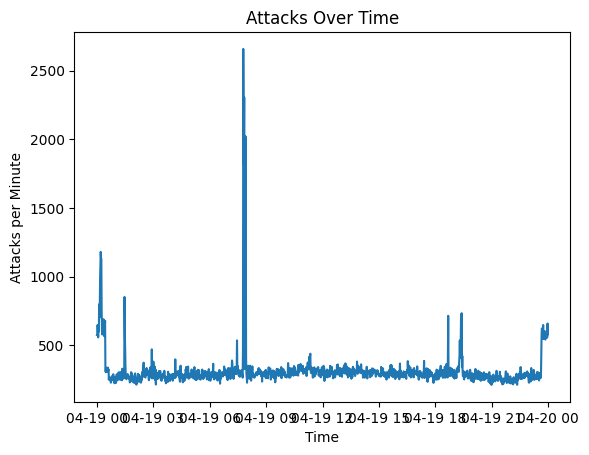

In [ ]:
dt['time'] = pd.to_datetime(df['time'])
dt.set_index('time', inplace=True)
attacks_per_minute = dt.resample('T').size()
plt.plot(attacks_per_minute.index, attacks_per_minute.values)
plt.title('Attacks Over Time')
plt.xlabel('Time')
plt.ylabel('Attacks per Minute')
plt.show()

In [ ]:
!pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok

deb https://ngrok-agent.s3.amazonaws.com buster main
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://ngrok-agent.s3.amazonaws.com buster InRelease [20.3 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [969 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 https://ngrok-agent.s3.amazonaws.com buster/main amd64 Packages [2,074 B]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:13 http://archive

In [ ]:
!ls

drive  sample_data


In [ ]:
!ngrok config add-authtoken 2NgrxhnQaYMXkFQlnLmCn7PHYG5_85D5TNdwXeExCBTgJKpZo

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from flask import Flask
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)

@app.route("/")
def home():
    return "<h1>GFG is great platform to learn</h1>"

app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://12cc-35-186-175-223.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [01/Apr/2023 10:32:59] "GET / HTTP/1.1" 200 -
